# FASTMRI brain: CTscan data preparation

### Author: M. Ravasi

Welcome to the "Deep Learning in Scientific Inverse Problems" course!

The aim of this second notebook is to create training pairs to be used later on to train some of the supervised learning algorithms presented in the course. 

Training pairs are created by first simulating CT scan data with a limited range of angles and by running the Filtered Back Projection (FBP) algorithm on such data. The true image and the FBP will represent the target and input of our networks.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import astra
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Load data
brains = np.load('../data/brains_trainingdata.npy')
nx, ny = brains[0].shape

In [3]:
# Create data and FBP
nangles = 41
distdetectors = 2
ndetectors = 160

sinograms = []
fbps = []

for brain in tqdm(brains):
    # Create sinogram
    vol_geom = astra.create_vol_geom(nx, ny)
    proj_geom = astra.create_proj_geom('parallel', distdetectors, ndetectors, np.linspace(0, np.pi, nangles, False))
    proj_id = astra.create_projector('strip', proj_geom, vol_geom)
    sinogram_id, sinogram = astra.create_sino(brain, proj_id)

    # Filtered back projection
    rec_id = astra.data2d.create('-vol', vol_geom)
    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = proj_id
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, 1)
    fbp = astra.data2d.get(rec_id)
    
    # Save results
    sinograms.append(sinogram)
    fbps.append(fbp)

    # Clean up
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.projector.delete(proj_id)


  0%|          | 0/1380 [00:00<?, ?it/s]

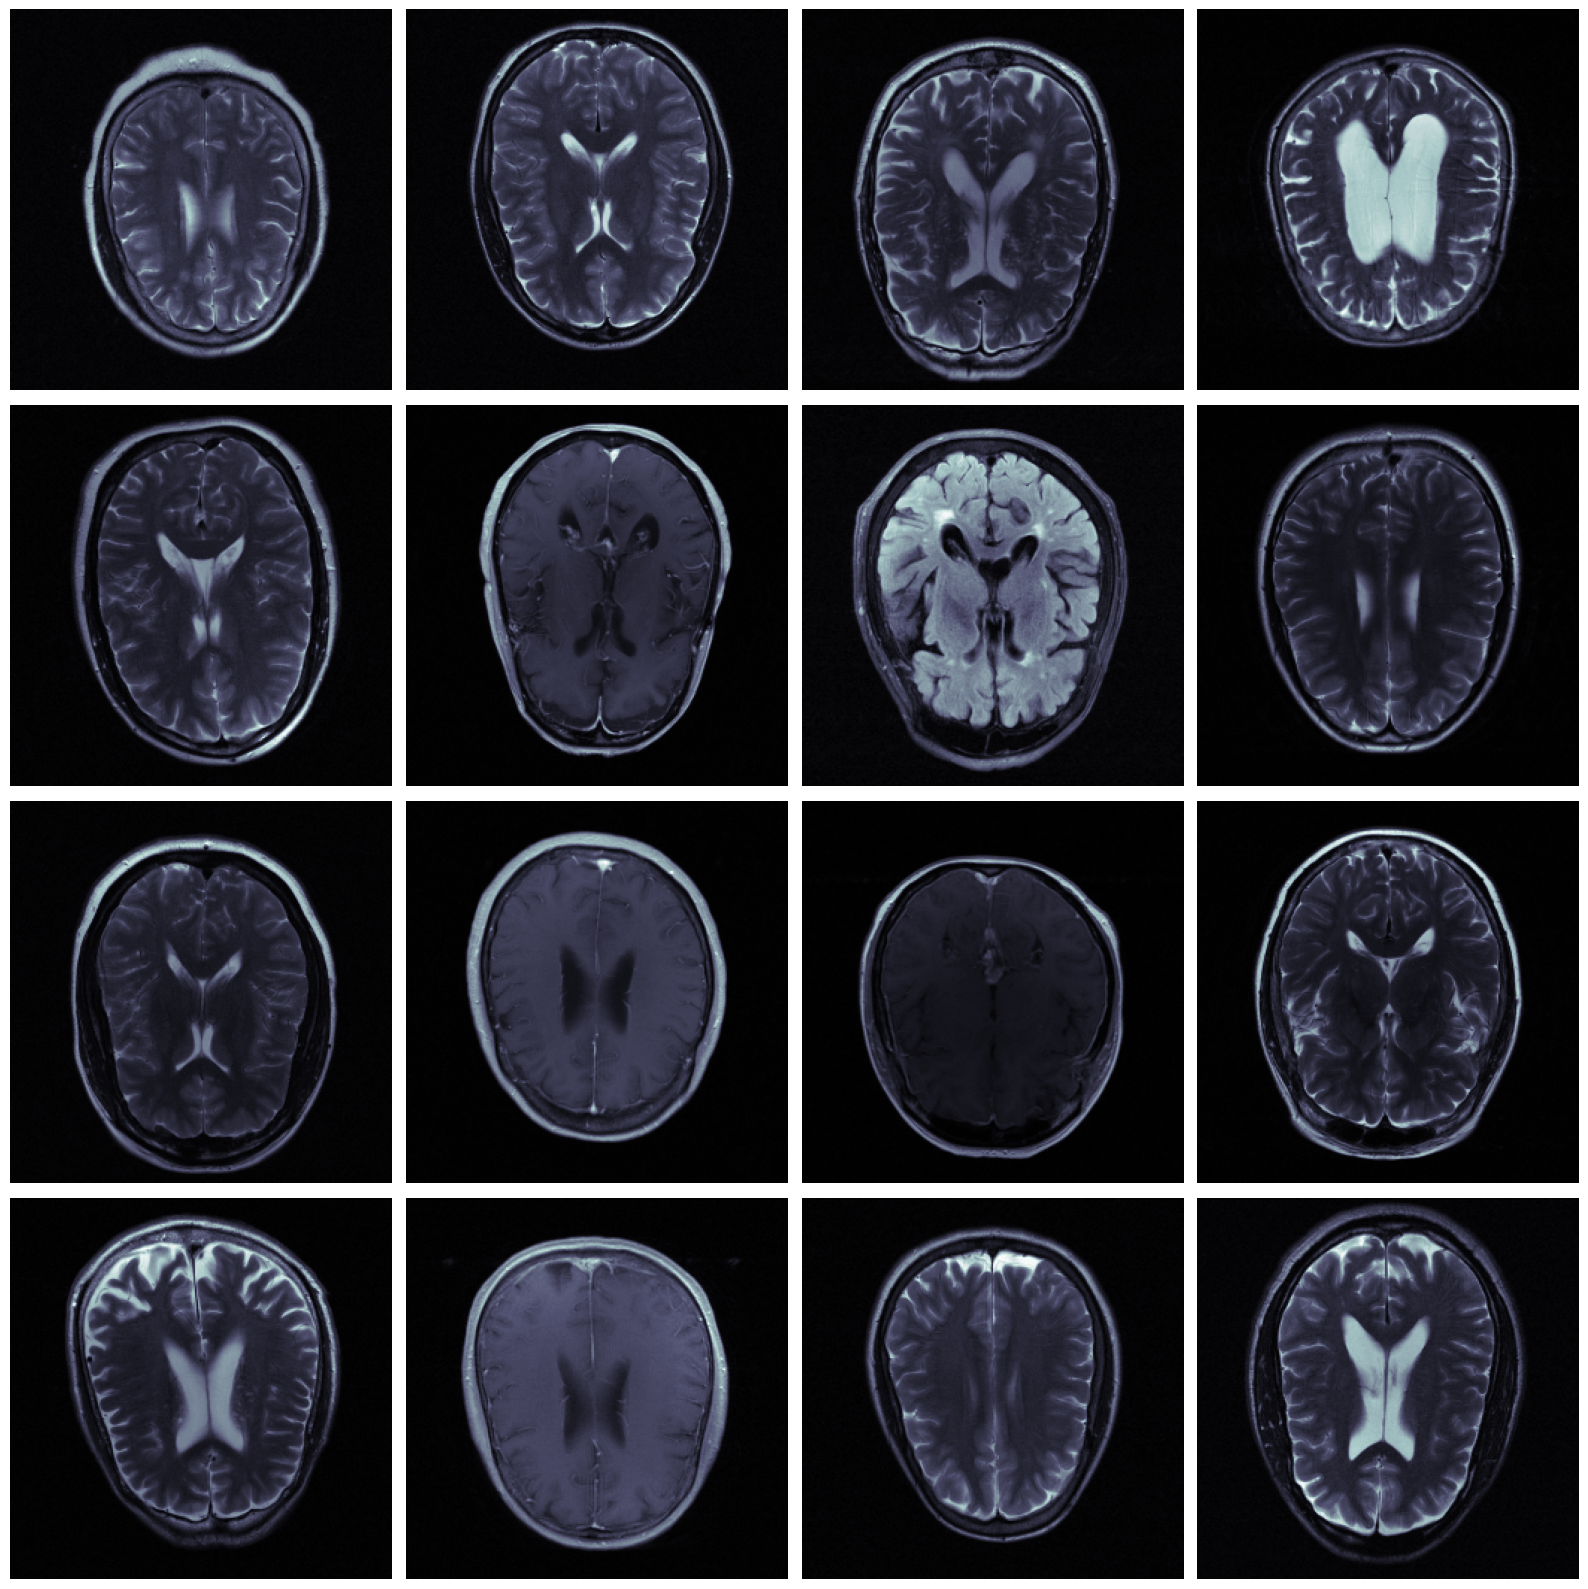

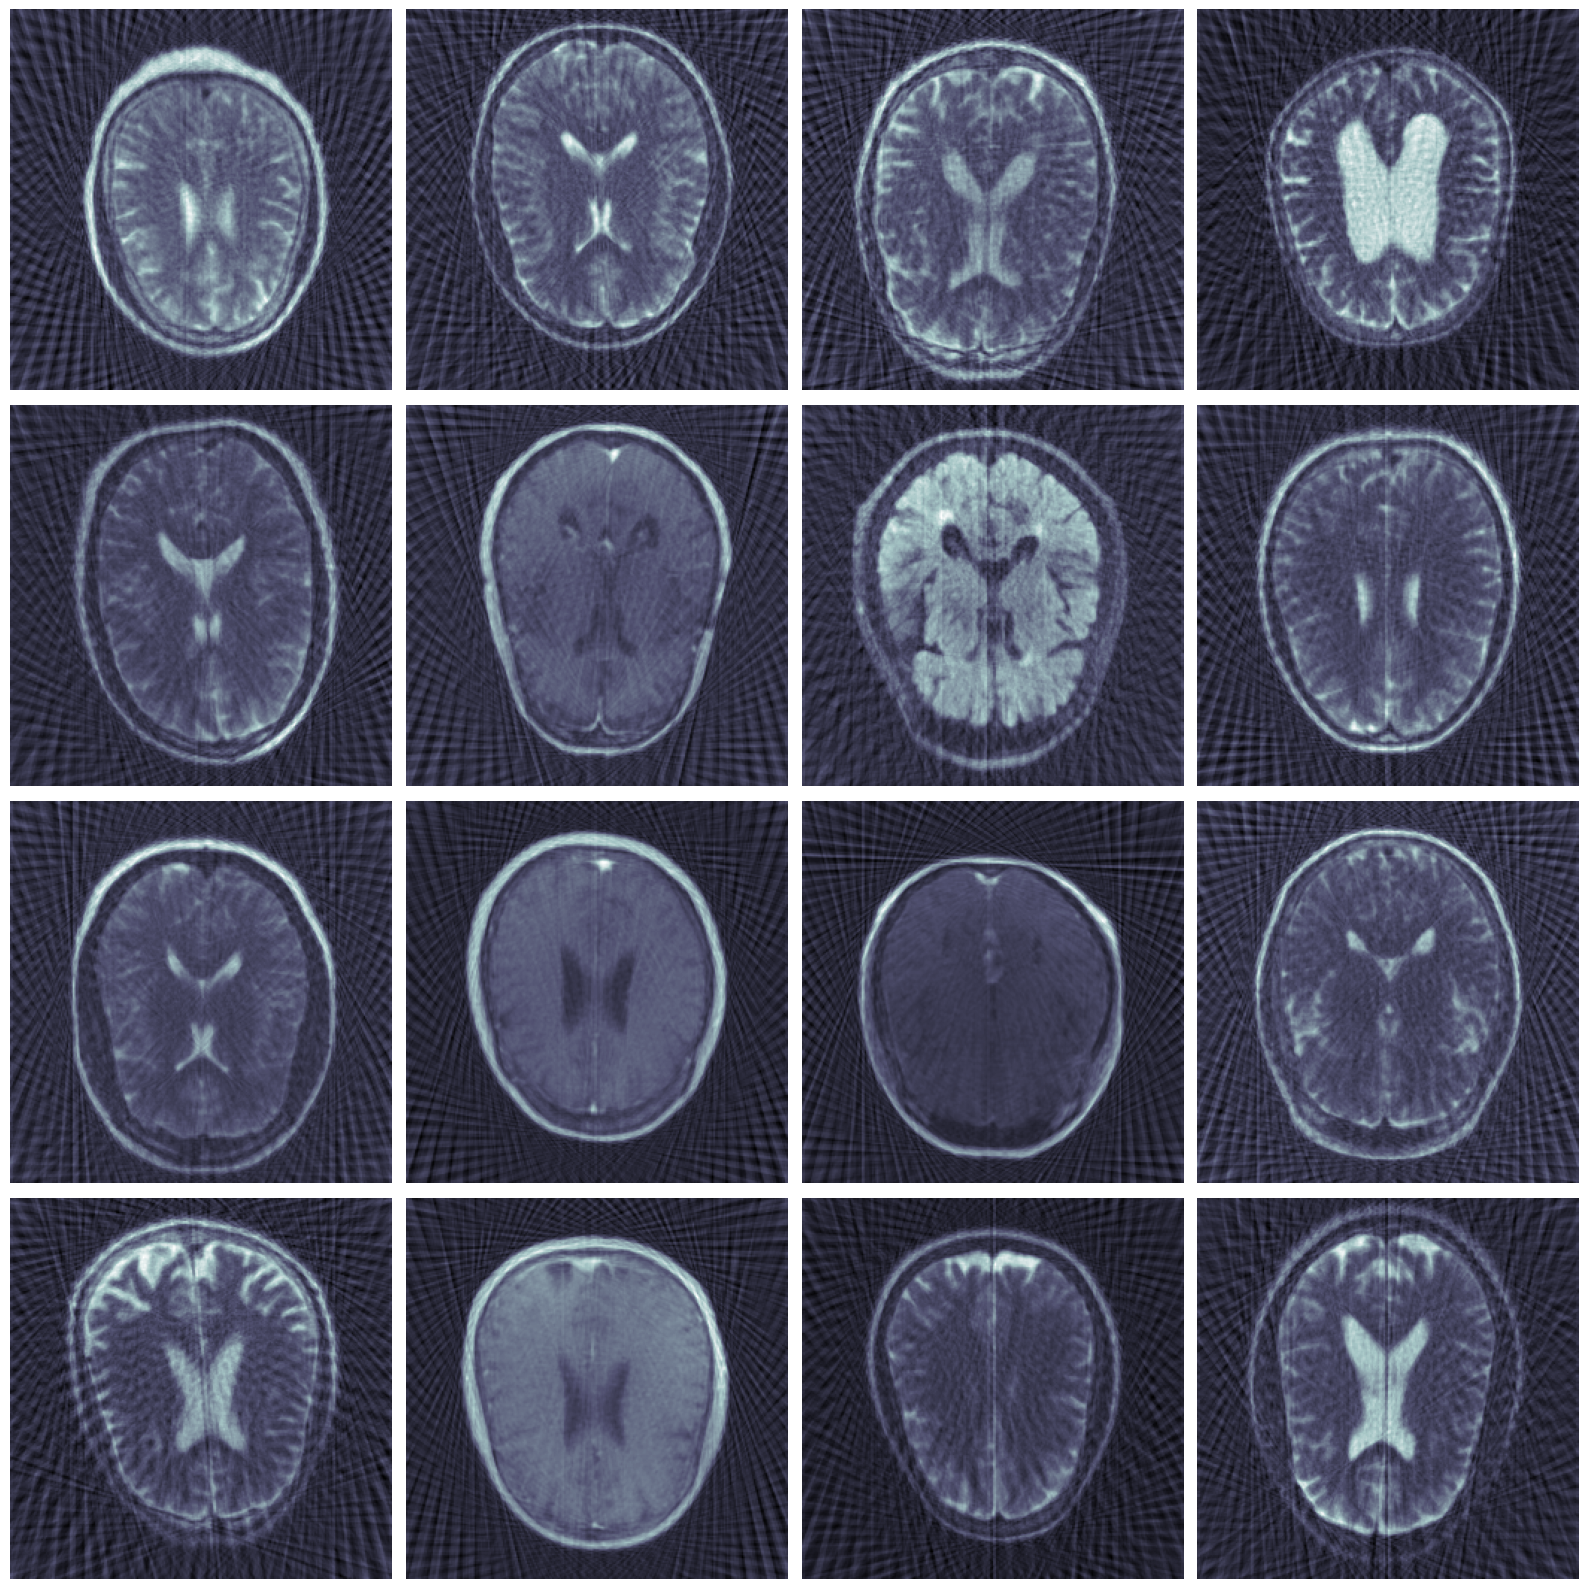

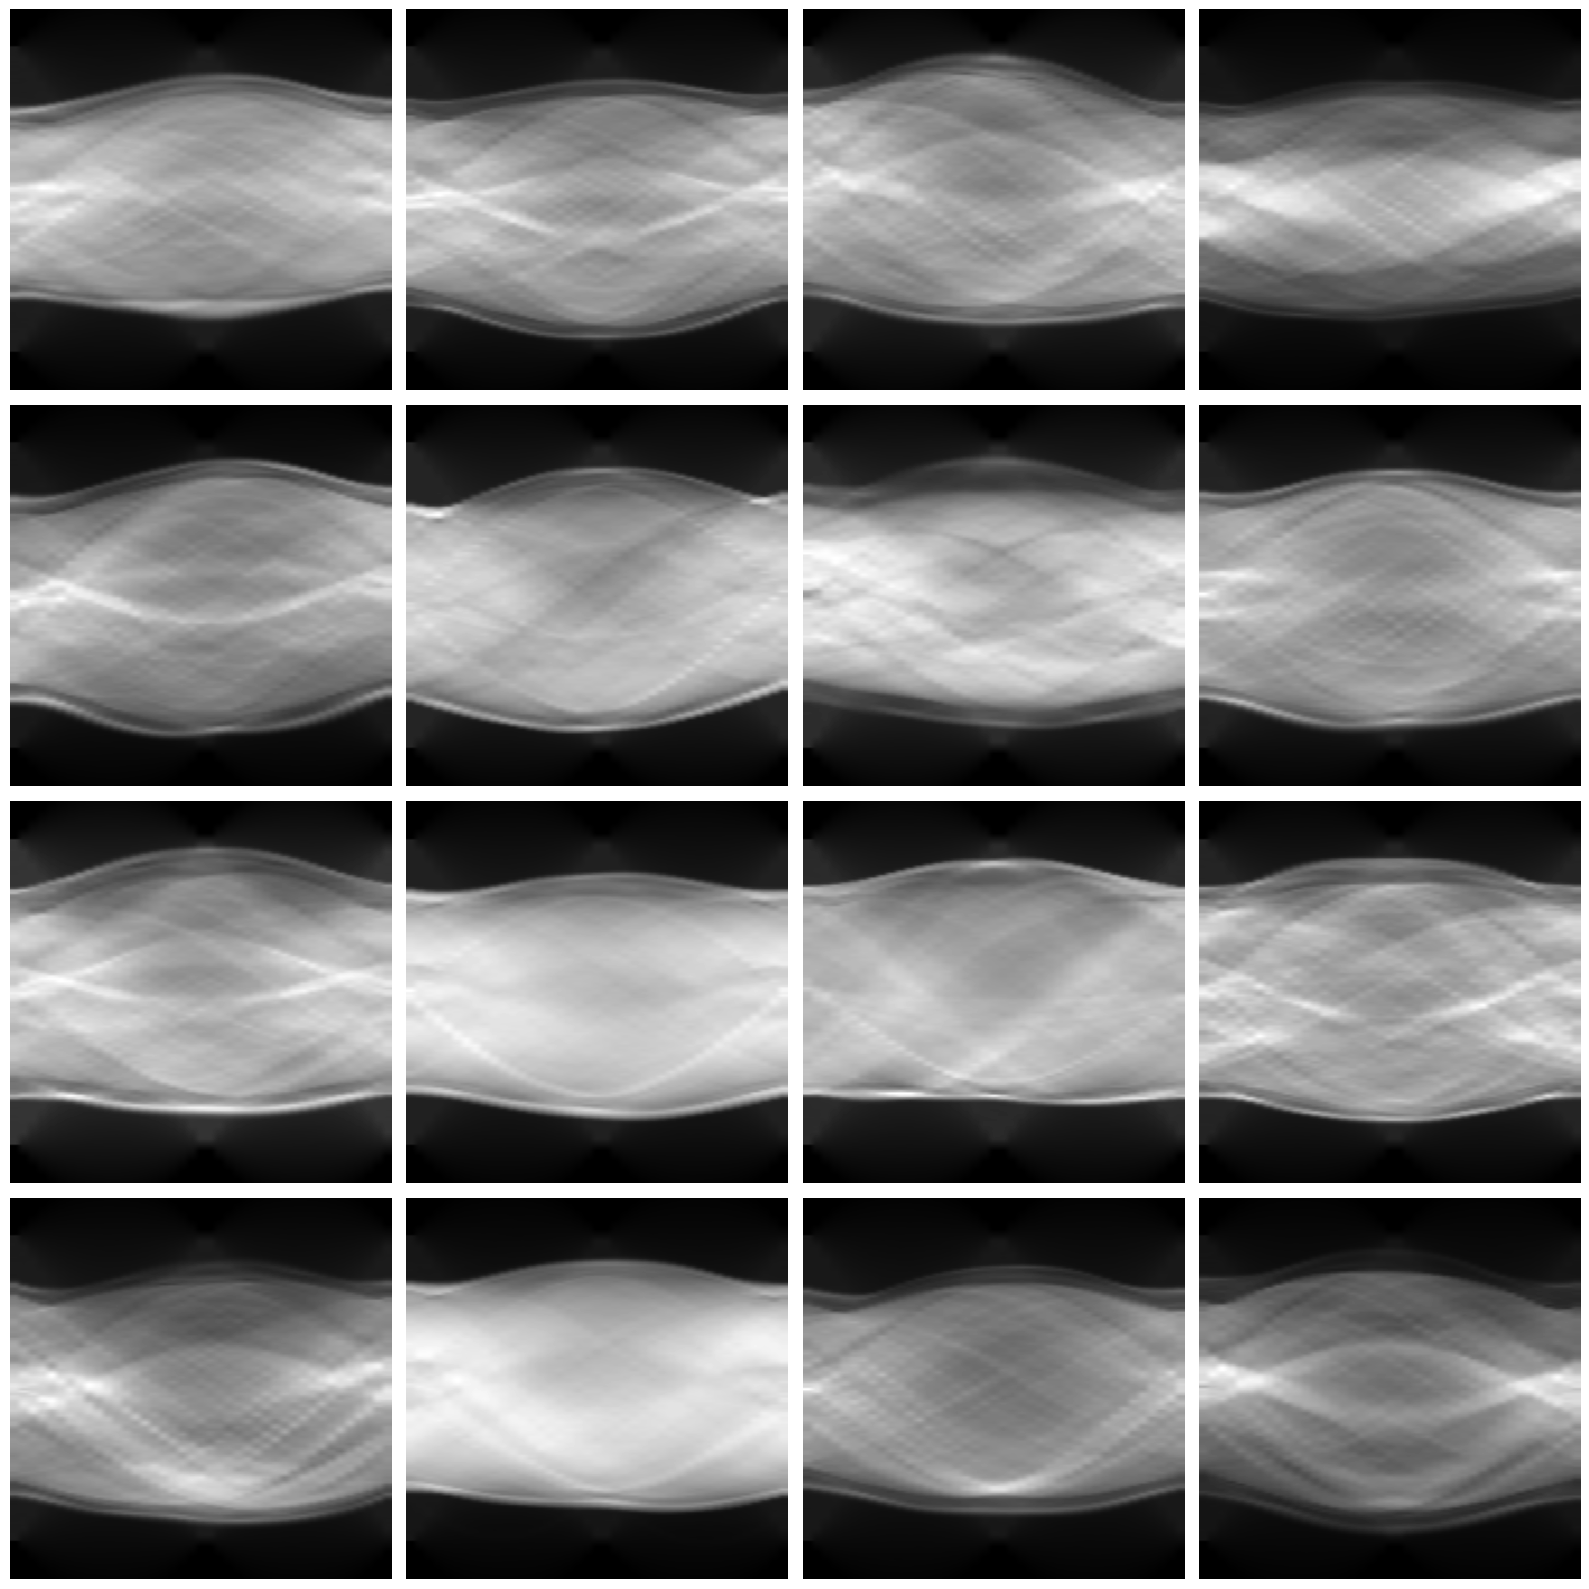

In [4]:
# Display random brain images
iimages = np.random.randint(0, len(brains), 16)
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(16, 16))
axs = axs.ravel()

for iax, iimage in enumerate(iimages):
    axs[iax].imshow(brains[iimage], cmap="bone")
    axs[iax].axis("off")
plt.tight_layout()

# Display random fbp images
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(16, 16))
axs = axs.ravel()

for iax, iimage in enumerate(iimages):
    axs[iax].imshow(fbps[iimage], cmap="bone")
    axs[iax].axis("off")
plt.tight_layout()

# Display random sinograms
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(16, 16))
axs = axs.ravel()

for iax, iimage in enumerate(iimages):
    axs[iax].imshow(sinograms[iimage].T, cmap="gray")
    axs[iax].axis("off")
    axs[iax].axis("tight")
plt.tight_layout()

In [5]:
# Save images
np.savez('../data/brains_fbp_trainingdata', brains=brains, fbps=fbps)